In [3]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import astropy
import scipy
import gatspy
from astropy.io import ascii
from StringIO import StringIO
from astropy.time import Time
import operator

import itertools

import pandas as pd
import sklearn
import seaborn as sns

from sklearn.decomposition import PCA 
from sklearn import linear_model
from sklearn.cross_validation import *
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

from collections import defaultdict

from scipy import optimize

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline

#DEFINE PI
pi = np.pi

fig_path = '../slope_project/' #set directory to save all figures
sns.set_style('ticks') #seaborn figure preferences
sns.set_context('paper', font_scale = 1.5)

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
def train_and_evaluate(clf, X_train, y_train, verbose = False):
    clf.fit(X_train, y_train)

    #create a k-fold cross validation iterator of k = 5 folds
    cv = KFold(X_train.shape[0], 5, shuffle = True)
    scores = cross_val_score(clf, X_train, y_train, cv = cv)

    if verbose == True:
        print("Coefficient of determination on training set:", clf.score(X_train, y_train))
        print("Average coefficient of determination using 5-fold crossvalidation:", np.mean(scores))
    
    return clf.score(X_train, y_train), np.mean(scores)

In [5]:
d = pd.read_csv('pool_dataset.csv')

In [6]:
pick_cor = d.drop(['Unnamed: 0','spr','yr'], axis = 1).T.as_matrix()

In [7]:
names = list(d.drop(['Unnamed: 0','spr','yr'], axis = 1).columns)
#remove Soblocoa from the pool
names.remove('Soblocoa')

In [8]:
def PlotCorr(cor, labels):
    
    #labels = ['Min1','Max1','Min2','Max2']
    
    fig = plt.figure()
    plt.imshow(cor, interpolation = 'nearest')
    plt.xticks(range(len(labels)), labels, rotation = 90)
    plt.yticks(range(len(labels)), labels)
    
    #for i in range(4):
    #    for j in range(4):
    #        plt.gca().annotate(str(cor[i][j].round(2)), xy = (i - 0.2,j + 0.1))
    sns.despine()
    
    return fig

In [9]:
def model(x):
    return 1 / (1 + np.exp(-x))

def LogLikelihood(x, clf):
    return model(x * clf.coef_ + clf.intercept_).ravel()

def ComputeExpectation(spread, model_list, verbose = False):

    favs_list = [] #total number of favorites

    for model in model_list:
        if verbose == True:
            print(model + ' : ' + str(LogLikelihood(spread, model_list[model])))
        favs_list.append(LogLikelihood(spread, model_list[model]))
    
    total_favs = sum(np.ravel(favs_list))
    
    if verbose == True:
        print('Total Favorites: ' + str(total_favs))

    possible_fav_points = len(model_list.keys()) - total_favs
    possible_und_points = total_favs
    
    if verbose == True:
        print('Poss. Fav. Points: ' + str(possible_fav_points))
        print('Poss. Und. Points: ' + str(possible_und_points))

    prob_fav_win = -0.026*(spread) + 0.5 #calculate probability favorite wins, based on spread
    prob_und_win =  1.0 - (-0.026*(spread) + 0.5) #calculate probability favorite wins, based on spread
    
    if verbose == True:
        print('Prob. Fav. Win: ' + str(prob_fav_win))
        print('Prob. Und. Win: ' + str(prob_und_win))
            
    expect_fav_points = possible_fav_points*prob_fav_win
    expect_und_points = possible_und_points*prob_und_win
    
    pick = []
    
    if expect_fav_points > expect_und_points:
        pick = 1
    elif expect_fav_points <= expect_und_points:
        pick = 0
    
    return expect_fav_points, expect_und_points, pick

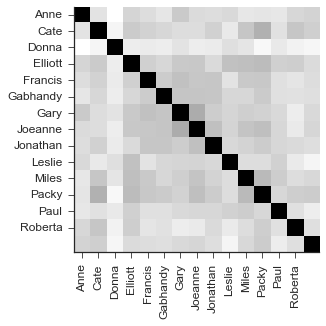

In [10]:
cor_fig = PlotCorr(np.corrcoef(pick_cor), names)

In [15]:
model_dict = defaultdict()

for name in names:
    X_train, X_test, y_train, y_test = train_test_split(d[['spr']], d[[name]], test_size = 0.75)
    log_clf = linear_model.LogisticRegression(C = 1e4)
    log_clf.fit(X_train, np.ravel(y_train))
    
    model_dict[name] = log_clf

model_dict['Jane'] = model_dict['Miles'] #model Jane as Miles

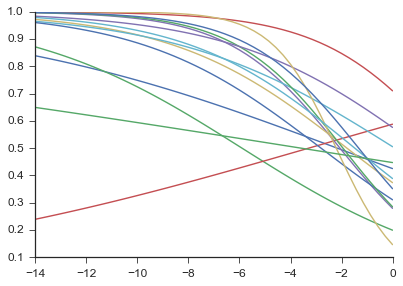

In [16]:
for name in names:
    plt.plot(np.linspace(-14,0), LogLikelihood(np.linspace(-14,0), model_dict[name]), label = name)
    sns.despine()

In [17]:
expects_fav = []
expects_und = []

for i in np.linspace(-16,0,100):
    expects_fav.append(ComputeExpectation(i,model_dict, verbose = False)[0])
    expects_und.append(ComputeExpectation(i,model_dict, verbose = False)[1])

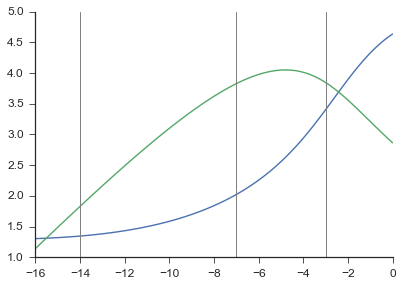

In [18]:
plt.plot(np.linspace(-16,0,100), expects_fav)
plt.plot(np.linspace(-16,0,100), expects_und)
plt.axvline(-3, lw = 1, color = 'gray')
plt.axvline(-7, lw = 1, color = 'gray')
plt.axvline(-14, lw = 1, color = 'gray')
sns.despine()

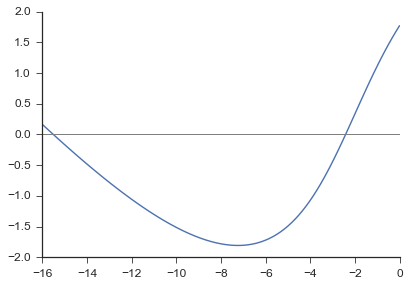

In [19]:
plt.plot(np.linspace(-16,0,100), np.array(expects_fav) - np.array(expects_und))
plt.axhline(0, lw = 1, c = 'gray')
sns.despine()

In [20]:
def SimulateSpreads(spreaddist, length):
    g_spreads = spreaddist[np.random.randint(0,len(spreaddist), length)]
    return np.array(g_spreads)

In [21]:
def MakePick(spread, model_dict):
    
    pick = defaultdict()
    
    for model in model_dict:
        
        if np.random.uniform(0,1) <= LogLikelihood(spread, model_dict[model]):
            pick[model] = 1
        else:
            pick[model] = 0
            
    return pick

def SimulateGame(spread):
    
    if np.random.uniform(0,1) <= -0.026*(spread) + 0.5:
        winner = 1
    else:
        winner = 0
    
    return winner

In [22]:
pix = []
games = []
franklona = []

for spread in SimulateSpreads(d['spr'],16):    
    pix.append(MakePick(spread, model_dict))
    games.append(SimulateGame(spread))
    franklona.append(ComputeExpectation(spread,model_dict)[-1])
    
pix = pd.DataFrame(pix)
games = pd.DataFrame(games)

pix['Franklona'] = franklona #add Franklona back into the pool

In [23]:
pix

,Anne,Cate,Donna,Elliott,Francis,Gabhandy,Gary,Jane,Joeanne,Jonathan,Leslie,Miles,Packy,Paul,Roberta,Franklona
0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,1
1,1,1,1,0,0,1,1,1,0,1,1,0,1,1,0,0
2,1,1,0,1,0,1,0,1,1,1,0,1,1,1,1,0
3,1,1,1,0,0,1,0,1,0,1,0,0,0,0,1,1
4,0,1,1,0,0,1,1,1,1,1,0,0,1,0,0,0
5,0,0,1,0,1,1,1,1,1,1,1,0,1,1,0,0
6,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0
7,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0
8,1,0,1,0,0,1,0,1,0,1,1,0,0,1,1,1
9,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1


In [541]:
final_points = []

und_pts = pix.sum(axis = 1)
fav_pts = len(pix.T) - und_pts

for i in range(len(pix)):
    for game in pix.loc[i]:
        if (game == games.loc[i][0]) & (game == 1):
            final_points.append(fav_pts)
        elif (game == games.loc[i][0]) & (game == 0):
            final_points.append(und_pts)
        else:
            final_points.append(0)

In [24]:
'''
WEEK 4:
week_spreads = [-7.0,-2.5,-9.0,-4.5,-1.5,-3.0,-3.0,-6.5,-3.5,-3.0,-3.0,-3.5,-8.0,-5.5,-4.0]

week_favs = ["Cincinnati", "Indianapolis", "Washington", "New England",\
            "Seattle", "Carolina", "Detroit", "Houston", "Baltimore", "Denver",\
            "Dallas", "San Diego", "Arizona", "Pittsburgh", "Minnesota"]

week_unds = ["Miami", "Jacksonville", "Cleveland", "Buffalo", "NY Jets", "Atlanta", "Chicago",\
             "Tennessee", "Oakland", "Tampa Bay", "San Francisco", "New Orleans","Los Angeles",\
             "Kansas City","NY Giants"]

WEEK 5:
week_spreads = [-4.5,-6.0,-3.5,-10.5,-7.0,-4.0,-3.0,-4.5,-6.0,-2.5,-4.0,-1.0,-7.0,-6.0]

week_favs = ["Arizona", "Minnesota", "Miami", "New England",\
            "Pittsburgh", "Baltimore", "Philadelphia", "Indianapolis", "Denver", "Los Angeles",\
            "Oakland", "Cincinnati", "Green Bay", "Carolina"]

week_unds = ["San Francisco", "Houston", "Tennessee", "Cleveland", "NY Jets", "Washington", "Detroit",\
             "Chicago", "Atlanta", "Buffalo", "San Diego", "Dallas","NY Giants",\
             "Tampa Bay"]

'''

week_spreads = [-3.5,-9.0,-3.0,-3.0,-7.5,-2.5,-8.0,-3.5,-7.0,-2.0,-1.0,-6.0,-4.0,-3.0, -8.0]

week_favs = ["Denver", "New England", "NY Giants", "Carolina",\
            "Pittsburgh", "Chicago", "Buffalo", "Detroit", "Tennessee", "Philadelphia",\
            "Oakland", "Seattle", "Green Bay", "Houston", "NY Jets"]

week_unds = ["San Diego", "Cincinnati", "Baltimore", "New Orleans", "Miami", "Jacksonville", "San Francisco",\
             "Los Angeles", "Cleveland", "Washington", "Kansas City", "Atlanta","Dallas",\
             "Indianapolis", "NY Jets"]

def PrintPicks(spreads, favs, unds):

    fav_boolean = []

    for spread in spreads: #for every spread during the week   
        fav_boolean.append(ComputeExpectation(spread,model_dict)[-1])
    
    print(fav_boolean)
    
    pick_names = []
    
    for i in range(len(fav_boolean)):
        if fav_boolean[i] == 1:
            pick_names.append(week_favs[i])
        elif fav_boolean[i] == 0:
            pick_names.append(week_unds[i])
            
    return(pick_names)

In [25]:
PrintPicks(week_spreads, week_favs, week_unds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]


['San Diego',
 'Cincinnati',
 'Baltimore',
 'New Orleans',
 'Miami',
 'Jacksonville',
 'San Francisco',
 'Los Angeles',
 'Cleveland',
 'Philadelphia',
 'Oakland',
 'Atlanta',
 'Dallas',
 'Indianapolis',
 'NY Jets']

In [26]:
expect_points = [max(ComputeExpectation(i,model_dict)) for i in week_spreads] 

In [27]:
sum(expect_points)

57.532089518393356

In [28]:
sum(expect_points)/len(week_spreads)

3.8354726345595571